<a href="https://colab.research.google.com/github/anshupandey/MSA-analytics/blob/main/MEM/Lab1_3_Mixed_Effect_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Module 9 – Mixed Effect Models (Labs 1–3)

**Dataset:** `Ocean_Hull_Insurance_datasetv2.csv` (provided)  
**Industry:** Ocean Hull Vessel Insurance

This notebook contains the first three labs:

- **Lab 1:** Exploring Fixed vs. Random Effects (OLS vs. Mixed-Effects)
- **Lab 2:** Hierarchical Structures & Random Slopes (Zone-level heterogeneity)
- **Lab 3:** Frequentist vs. Bayesian (template + fallback)

> ⚠️ *Note:* The provided dataset is a cross-section (one row per vessel). It **does not contain time/longitudinal repeats** per vessel. We therefore demonstrate *hierarchical* mixed-effects with group-level (Operating Zone) random effects and random slopes. For true longitudinal modelling, add a time column (e.g., policy year per vessel) and follow the template in Lab 2 (Longitudinal Note).


In [2]:

# ==== Setup ====
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
from pathlib import Path

# Matplotlib settings (per teaching guidelines: single-plot charts, no custom colors/styles)
%matplotlib inline

# Paths
DATA_PATH = "https://raw.githubusercontent.com/anshupandey/MSA-analytics/refs/heads/main/datasets/Ocean_Hull_Insurance_datasetv2.csv"

# Load data
df = pd.read_csv(DATA_PATH)

print('Shape:', df.shape)
print('Columns:', df.columns.tolist())

# Quick peek
df.head()


Shape: (300, 15)
Columns: ['Vessel_ID', 'Vessel_Type', 'Operating_Zone', 'Vessel_Age', 'Flag_State', 'Inspection_Status', 'Weather_Risk', 'Piracy_Risk', 'Claim_Occurred', 'Claim_Amount', 'Premium', 'Sum_Insured', 'Daily_Return', 'Initial_Investment', 'Final_Value']


,Vessel_ID,Vessel_Type,Operating_Zone,Vessel_Age,Flag_State,Inspection_Status,Weather_Risk,Piracy_Risk,Claim_Occurred,Claim_Amount,Premium,Sum_Insured,Daily_Return,Initial_Investment,Final_Value
0,1,Container Ship,Strait of Malacca,19,Marshall Islands,Overdue,Moderate,Moderate,0,0,159500,14050000,0.000997,95700.0,104676.840752
1,2,Container Ship,Strait of Malacca,40,Marshall Islands,Up-to-date,High,High,0,0,170000,13000000,0.000362,102000.0,105374.760051
2,3,Tanker,Indian Ocean,26,Greece,Delayed,Low,Low,0,0,193000,18700000,0.001148,115800.0,128393.183954
3,4,Bulk Carrier,South China Sea,7,Greece,Up-to-date,Moderate,Low,0,0,123500,11650000,0.002023,74100.0,88881.524555
4,5,Offshore Support Vessel,Mediterranean,18,Liberia,Delayed,Low,Low,0,0,109000,7100000,0.000266,65400.0,66983.429972



## Data Processing (Used in all labs)

We will:
1. Inspect missing values.
2. Engineer a **log-claim** outcome (skew reduction): `log_claim = log(Claim_Amount + 1)`.
3. Keep key predictors (fixed effects) commonly used in insurance risk:
   - `Vessel_Age`, `Premium`, `Sum_Insured`
   - Categorical risk drivers: `Vessel_Type`, `Inspection_Status`, `Weather_Risk`, `Piracy_Risk`
4. Use **Operating_Zone** as the *grouping level* for random effects to capture unobserved spatial/operational heterogeneity.


In [3]:

# ==== Data Processing & Checks ====

# Basic NA check
na_summary = df.isna().sum().sort_values(ascending=False)
print('Missing values by column:\n', na_summary)


Missing values by column:
 Vessel_ID             0
Vessel_Type           0
Operating_Zone        0
Vessel_Age            0
Flag_State            0
Inspection_Status     0
Weather_Risk          0
Piracy_Risk           0
Claim_Occurred        0
Claim_Amount          0
Premium               0
Sum_Insured           0
Daily_Return          0
Initial_Investment    0
Final_Value           0
dtype: int64


In [4]:
# Create target for continuous modelling
df['log_claim'] = np.log1p(df['Claim_Amount'].astype(float))

# Basic sanity checks
print('\nClaim_Amount zero rate:', (df['Claim_Amount'] == 0).mean())
print('log_claim summary:\n', df['log_claim'].describe())




Claim_Amount zero rate: 0.7666666666666667
log_claim summary:
 count    300.000000
mean       3.370222
std        6.122520
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       15.418180
Name: log_claim, dtype: float64


In [5]:
# Ensure categorical dtypes for formula handling
categorical_cols = ['Vessel_Type', 'Operating_Zone', 'Flag_State',
                    'Inspection_Status']
for c in categorical_cols:
    df[c] = df[c].astype('category')


# Keep a modelling frame
model_cols = ['log_claim', 'Vessel_Age', 'Premium', 'Sum_Insured',
              'Vessel_Type', 'Inspection_Status', 'Operating_Zone']
work = df[model_cols].dropna().copy()

print('\nModelling frame shape:', work.shape)
work.head()


Modelling frame shape: (300, 7)


,log_claim,Vessel_Age,Premium,Sum_Insured,Vessel_Type,Inspection_Status,Operating_Zone
0,0.0,19,159500,14050000,Container Ship,Overdue,Strait of Malacca
1,0.0,40,170000,13000000,Container Ship,Up-to-date,Strait of Malacca
2,0.0,26,193000,18700000,Tanker,Delayed,Indian Ocean
3,0.0,7,123500,11650000,Bulk Carrier,Up-to-date,South China Sea
4,0.0,18,109000,7100000,Offshore Support Vessel,Delayed,Mediterranean



### Quick EDA

We’ll examine:
- Distribution of **log_claim**
- Average claims by **Operating_Zone** (group heterogeneity glance)


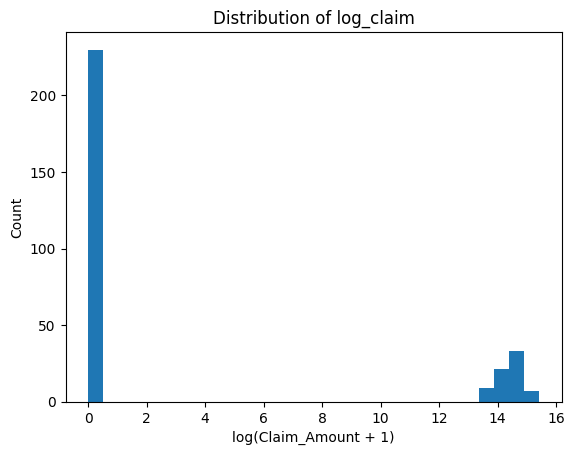

Operating_Zone
Strait of Malacca    8.024567
South China Sea      3.115020
Indian Ocean         2.403114
North Atlantic       2.046658
Mediterranean        1.415976
Name: log_claim, dtype: float64


/tmp/ipython-input-1084510661.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  zone_means = work.groupby('Operating_Zone')['log_claim'].mean().sort_values(ascending=False)


In [6]:

# Distribution of log_claim
plt.figure()
work['log_claim'].plot.hist(bins=30)
plt.title('Distribution of log_claim')
plt.xlabel('log(Claim_Amount + 1)')
plt.ylabel('Count')
plt.show()

# Zone-level mean log_claim
zone_means = work.groupby('Operating_Zone')['log_claim'].mean().sort_values(ascending=False)
print(zone_means.head(10))



---
## Lab 1 – Exploring Fixed vs. Random Effects

**Goal:** Understand when a variable should be treated as fixed or random.  
We compare an **OLS (fixed-effects-only)** model vs. a **Mixed-Effects** model with **random intercepts by Operating_Zone**.


In [7]:
import numpy as np, pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
import patsy


In [8]:
tmp = work.copy()

In [9]:
# 0) Keep only zones with >= 2 observations (helps RE estimation)
zone_counts = tmp['Operating_Zone'].value_counts()
tmp = tmp[tmp['Operating_Zone'].isin(zone_counts[zone_counts >= 2].index)].copy()
tmp['Operating_Zone'] = tmp['Operating_Zone'].astype('category')

In [10]:
# 1) Collapse rare categorical levels (min 2 rows)
def collapse_rare(series, min_count=2, other='Other'):
    vc = series.value_counts()
    rare = vc[vc < min_count].index
    return series.apply(lambda x: other if x in rare else x).astype('category')

for cat in ['Vessel_Type','Inspection_Status']:
    tmp[cat] = collapse_rare(tmp[cat], min_count=2).astype(str)


In [11]:
# 2) Scale numerics; drop Sum_Insured if almost collinear with Premium
corr_ps = tmp[['Premium','Sum_Insured']].corr().iloc[0,1]
drop_sum_insured = abs(corr_ps) > 0.95

numz = ['Vessel_Age','Premium'] + ([] if drop_sum_insured else ['Sum_Insured'])
scaler = StandardScaler()
tmp[[c+'_z' for c in numz]] = scaler.fit_transform(tmp[numz])


In [12]:
# 3) AUTO-DROP fixed effects with zero within-zone variance (non-identifiable with RI)
def has_within_group_variation(s, g):
    # True if at least one group shows >1 unique value (for numeric) or >1 level (for cat)
    by = s.groupby(g)
    # for numerics
    if np.issubdtype(s.dropna().dtype, np.number):
        return any(by.nunique() > 1)
    # for categoricals/objects
    return any(by.nunique() > 1)

fixed_blocks = {
    'NUM': ['Vessel_Age_z','Premium_z'] + ([] if drop_sum_insured else ['Sum_Insured_z']),
    'VT' : ['C(Vessel_Type)'],
    'IS' : ['C(Inspection_Status)'],
}


In [14]:
zone_counts = tmp['Operating_Zone'].value_counts()
zone_counts

,count
Operating_Zone,
North Atlantic,71
Indian Ocean,61
Mediterranean,61
Strait of Malacca,61
South China Sea,46


In [30]:
# Filter out blocks with zero within-zone variation
kept_blocks = []
for tag, terms in fixed_blocks.items():
    keep = True
    for t in terms:
        if t.startswith('C('):  # categorical in patsy form
            col = t[2:-1]
            if not has_within_group_variation(tmp[col], tmp['Operating_Zone']):
                keep = False
                break
        else:  # numeric z
            base = t.replace('_z','')
            if not has_within_group_variation(tmp[base], tmp['Operating_Zone']):
                keep = False
                break
    if keep:
        kept_blocks.append(tag)

print("Blocks with within-zone variation:", kept_blocks)


Blocks with within-zone variation: ['NUM', 'VT', 'IS']


/tmp/ipython-input-3386338163.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  by = s.groupby(g)


In [31]:
# 4) Incremental fit: start minimal, add blocks one by one; skip if singular
def try_mixed(rhs_terms):
    formula = "log_claim ~ " + " + ".join(rhs_terms)
    try:
        fit = sm.MixedLM.from_formula(formula, groups='Operating_Zone',
                                      re_formula='1', data=tmp).fit(reml=True, method='lbfgs', maxiter=200)
        return fit
    except Exception as e:
        return e

# minimal numeric core
rhs = fixed_blocks['NUM'].copy()
print("Trying minimal NUM model:", rhs)
fit_best = try_mixed(rhs)
if isinstance(fit_best, Exception):
    # last resort: drop to a single numeric (Vessel_Age_z) and re-try
    rhs = ['Vessel_Age_z']
    print("Fallback minimal model:", rhs)
    fit_best = try_mixed(rhs)

Trying minimal NUM model: ['Vessel_Age_z', 'Premium_z', 'Sum_Insured_z']


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [32]:
# add categorical blocks if available & identifiable
for tag in ['VT','IS','WR','PR']:
    if tag in kept_blocks:
        candidate_rhs = rhs + fixed_blocks[tag]
        print("Trying to add block", tag, "->", candidate_rhs)
        fit_try = try_mixed(candidate_rhs)
        if not isinstance(fit_try, Exception):
            rhs, fit_best = candidate_rhs, fit_try
            print("Added", tag)
        else:
            print("Skipping", tag, "due to singularity / convergence:", fit_try)

print("\nFINAL FORMULA:", "log_claim ~ " + " + ".join(rhs))
print(fit_best.summary() if not isinstance(fit_best, Exception) else fit_best)


Trying to add block VT -> ['Vessel_Age_z', 'Premium_z', 'Sum_Insured_z', 'C(Vessel_Type)']
Added VT
Trying to add block IS -> ['Vessel_Age_z', 'Premium_z', 'Sum_Insured_z', 'C(Vessel_Type)', 'C(Inspection_Status)']
Added IS

FINAL FORMULA: log_claim ~ Vessel_Age_z + Premium_z + Sum_Insured_z + C(Vessel_Type) + C(Inspection_Status)
                                Mixed Linear Model Regression Results
Model:                            MixedLM                Dependent Variable:                log_claim
No. Observations:                 300                    Method:                            REML     
No. Groups:                       5                      Scale:                             32.3090  
Min. group size:                  46                     Log-Likelihood:                    inf      
Max. group size:                  71                     Converged:                         Yes      
Mean group size:                  60.0                                                 

/usr/local/lib/python3.11/dist-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python3.11/d

In [33]:
formula = "log_claim ~ " + " + ".join(rhs)
print(formula)


log_claim ~ Vessel_Age_z + Premium_z + Sum_Insured_z + C(Vessel_Type) + C(Inspection_Status)


In [34]:
ols_model = smf.ols(formula,data=tmp).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_claim   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                 -0.016
Method:                 Least Squares   F-statistic:                    0.2276
Date:                Thu, 14 Aug 2025   Prob (F-statistic):              0.968
Time:                        14:35:28   Log-Likelihood:                -968.08
No. Observations:                 300   AIC:                             1950.
Df Residuals:                     293   BIC:                             1976.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

In [35]:
try:
    print("\nAIC comparison:", {
        "OLS_AIC": float(ols_model.aic),
        "Mixed_AIC": float(fit_best.aic)
    })
except Exception:
    print("\nAIC comparison not available (MixedLM did not fit).")


AIC comparison: {'OLS_AIC': 1950.1508821882044, 'Mixed_AIC': nan}


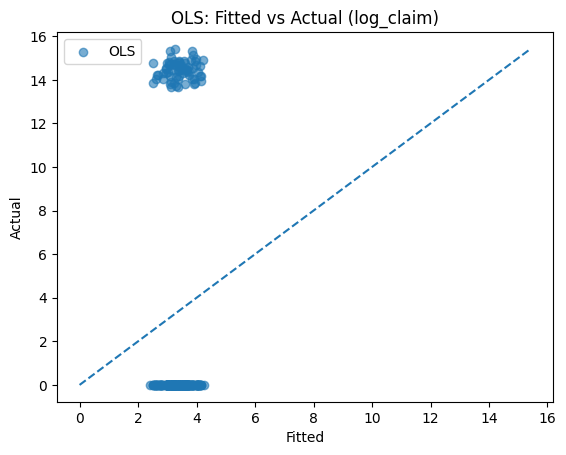

ValueError: Cannot predict random effects from singular covariance structure.

In [36]:
y_all = work['log_claim']

# (a) OLS: fitted vs actual
y_ols = y_all.loc[ols_model.fittedvalues.index]
f_ols = ols_model.fittedvalues
plt.figure()
plt.scatter(f_ols, y_ols, alpha=0.6,label='OLS')
lo, hi = min(f_ols.min(), y_ols.min()), max(f_ols.max(), y_ols.max())
plt.plot([lo, hi], [lo, hi], linestyle='--')
plt.title('OLS: Fitted vs Actual (log_claim)')
plt.xlabel('Fitted'); plt.ylabel('Actual')
plt.legend()
plt.show()

# (b) MixedLM: fitted vs actual (only if fit succeeded)
if not isinstance(fit_best, Exception):
    y_mx = y_all.loc[fit_best.fittedvalues.index]
    f_mx = fit_best.fittedvalues
    plt.figure()
    plt.scatter(f_mx, y_mx, alpha=0.6)
    lo, hi = min(f_mx.min(), y_mx.min()), max(f_mx.max(), y_mx.max())
    plt.plot([lo, hi], [lo, hi], linestyle='--')
    plt.title('MixedLM (RI): Fitted vs Actual (log_claim)')
    plt.xlabel('Fitted'); plt.ylabel('Actual')
    plt.show()

    # (c) Residuals vs fitted
    plt.figure()
    plt.scatter(f_mx, fit_best.resid, alpha=0.6)
    plt.axhline(0, linestyle='--')
    plt.title('MixedLM (RI): Residuals vs Fitted')
    plt.xlabel('Fitted'); plt.ylabel('Residuals')
    plt.show()

    # (d) Q–Q plot of residuals
    plt.figure()
    sm.qqplot(fit_best.resid, line='45')
    plt.title('MixedLM (RI): Residuals Q–Q')
    plt.show()

    # (e) Random intercept BLUPs (caterpillar)
    ranef = fit_best.random_effects
    zone_intercepts = pd.Series({
        k: (v.values[0] if hasattr(v, 'values')
            else (v[0] if isinstance(v, (list, np.ndarray, pd.Series)) else float(v)))
        for k, v in ranef.items()
    })
    plt.figure()
    zone_intercepts.sort_values().plot(kind='barh')
    plt.title('Operating_Zone Random Intercepts (BLUPs)')
    plt.xlabel('Intercept offset'); plt.ylabel('Operating_Zone')
    plt.tight_layout()
    plt.show()


**Discussion prompts (record your notes):**
- Did the mixed model reduce AIC vs OLS?
- Which fixed effects remain significant after adding random intercepts?
- Why might **Operating_Zone** heterogeneity matter for hull insurance pricing or risk?



---
## Lab 2 – Frequentist vs. Bayesian Approaches

**Goal:** Compare estimates and interval interpretations across frequentist and Bayesian frameworks.

- **Frequentist**: We already fit using `statsmodels` MixedLM.
- **Bayesian**: Below is a **template** using `PyMC`/`Bambi`. This environment may not have these libraries preinstalled. The cell checks availability and, if missing, **skips execution** but leaves **ready-to-run code** for your environment.


In [38]:
!pip install bambi --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.2/109.2 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 3.3 MB/s eta 0:00:00


In [39]:
# ==== Lab 2: Frequentist vs Bayesian (Template + Fallback) ====
import importlib, sys

has_bambi = importlib.util.find_spec('bambi') is not None
has_pymc = importlib.util.find_spec('pymc') is not None

print('Has bambi:', has_bambi)
print('Has pymc:', has_pymc)


Has bambi: True
Has pymc: True


In [40]:
if has_bambi and has_pymc:
    import bambi as bmb
    # Bayesian mixed model analogous to Lab 2
    # Using weakly-informative priors by default
    model_bayes = bmb.Model(
        'log_claim ~ Vessel_Age + Premium + Sum_Insured + 1 + (1 + Vessel_Age|Operating_Zone) + '
        'C(Vessel_Type) + C(Inspection_Status)',
        data=work
    )
    idata = model_bayes.fit(draws=1000, chains=2, cores=1)
    print(idata)
    # Posterior summaries
    print(model_bayes)
else:
    print('\nBayesian libraries not available in this runtime.')
    print('Template code is provided below for environments with PyMC/Bambi installed.')


Output()

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data


AttributeError: 'Model' object has no attribute 'summary'

In [43]:
model_bayes

       Formula: log_claim ~ Vessel_Age + Premium + Sum_Insured + 1 + (1 + Vessel_Age|Operating_Zone) + C(Vessel_Type) + C(Inspection_Status)
        Family: gaussian
          Link: mu = identity
  Observations: 300
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 3.3702, sigma: 109.2709)
            Vessel_Age ~ Normal(mu: 0.0, sigma: 1.5335)
            Premium ~ Normal(mu: 0.0, sigma: 0.0005)
            Sum_Insured ~ Normal(mu: 0.0, sigma: 0.0)
            C(Vessel_Type) ~ Normal(mu: [0. 0. 0.], sigma: [34.033  50.9359 32.4976])
            C(Inspection_Status) ~ Normal(mu: [0. 0.], sigma: [35.1347 30.5949])
        
        Group-level effects
            1|Operating_Zone ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 109.2709))
            Vessel_Age|Operating_Zone ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.5335))
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 6.1123)
------
* To see a plot of t

array([[<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'Vessel_Age'}>],
       [<Axes: title={'center': 'Premium'}>,
        <Axes: title={'center': 'Sum_Insured'}>,
        <Axes: title={'center': 'C(Vessel_Type)\nContainer Ship'}>],
       [<Axes: title={'center': 'C(Vessel_Type)\nOffshore Support Vessel'}>,
        <Axes: title={'center': 'C(Vessel_Type)\nTanker'}>,
        <Axes: title={'center': 'C(Inspection_Status)\nOverdue'}>],
       [<Axes: title={'center': 'C(Inspection_Status)\nUp-to-date'}>,
        <Axes: title={'center': '1|Operating_Zone_sigma'}>,
        <Axes: title={'center': 'Vessel_Age|Operating_Zone_sigma'}>]],
      dtype=object)

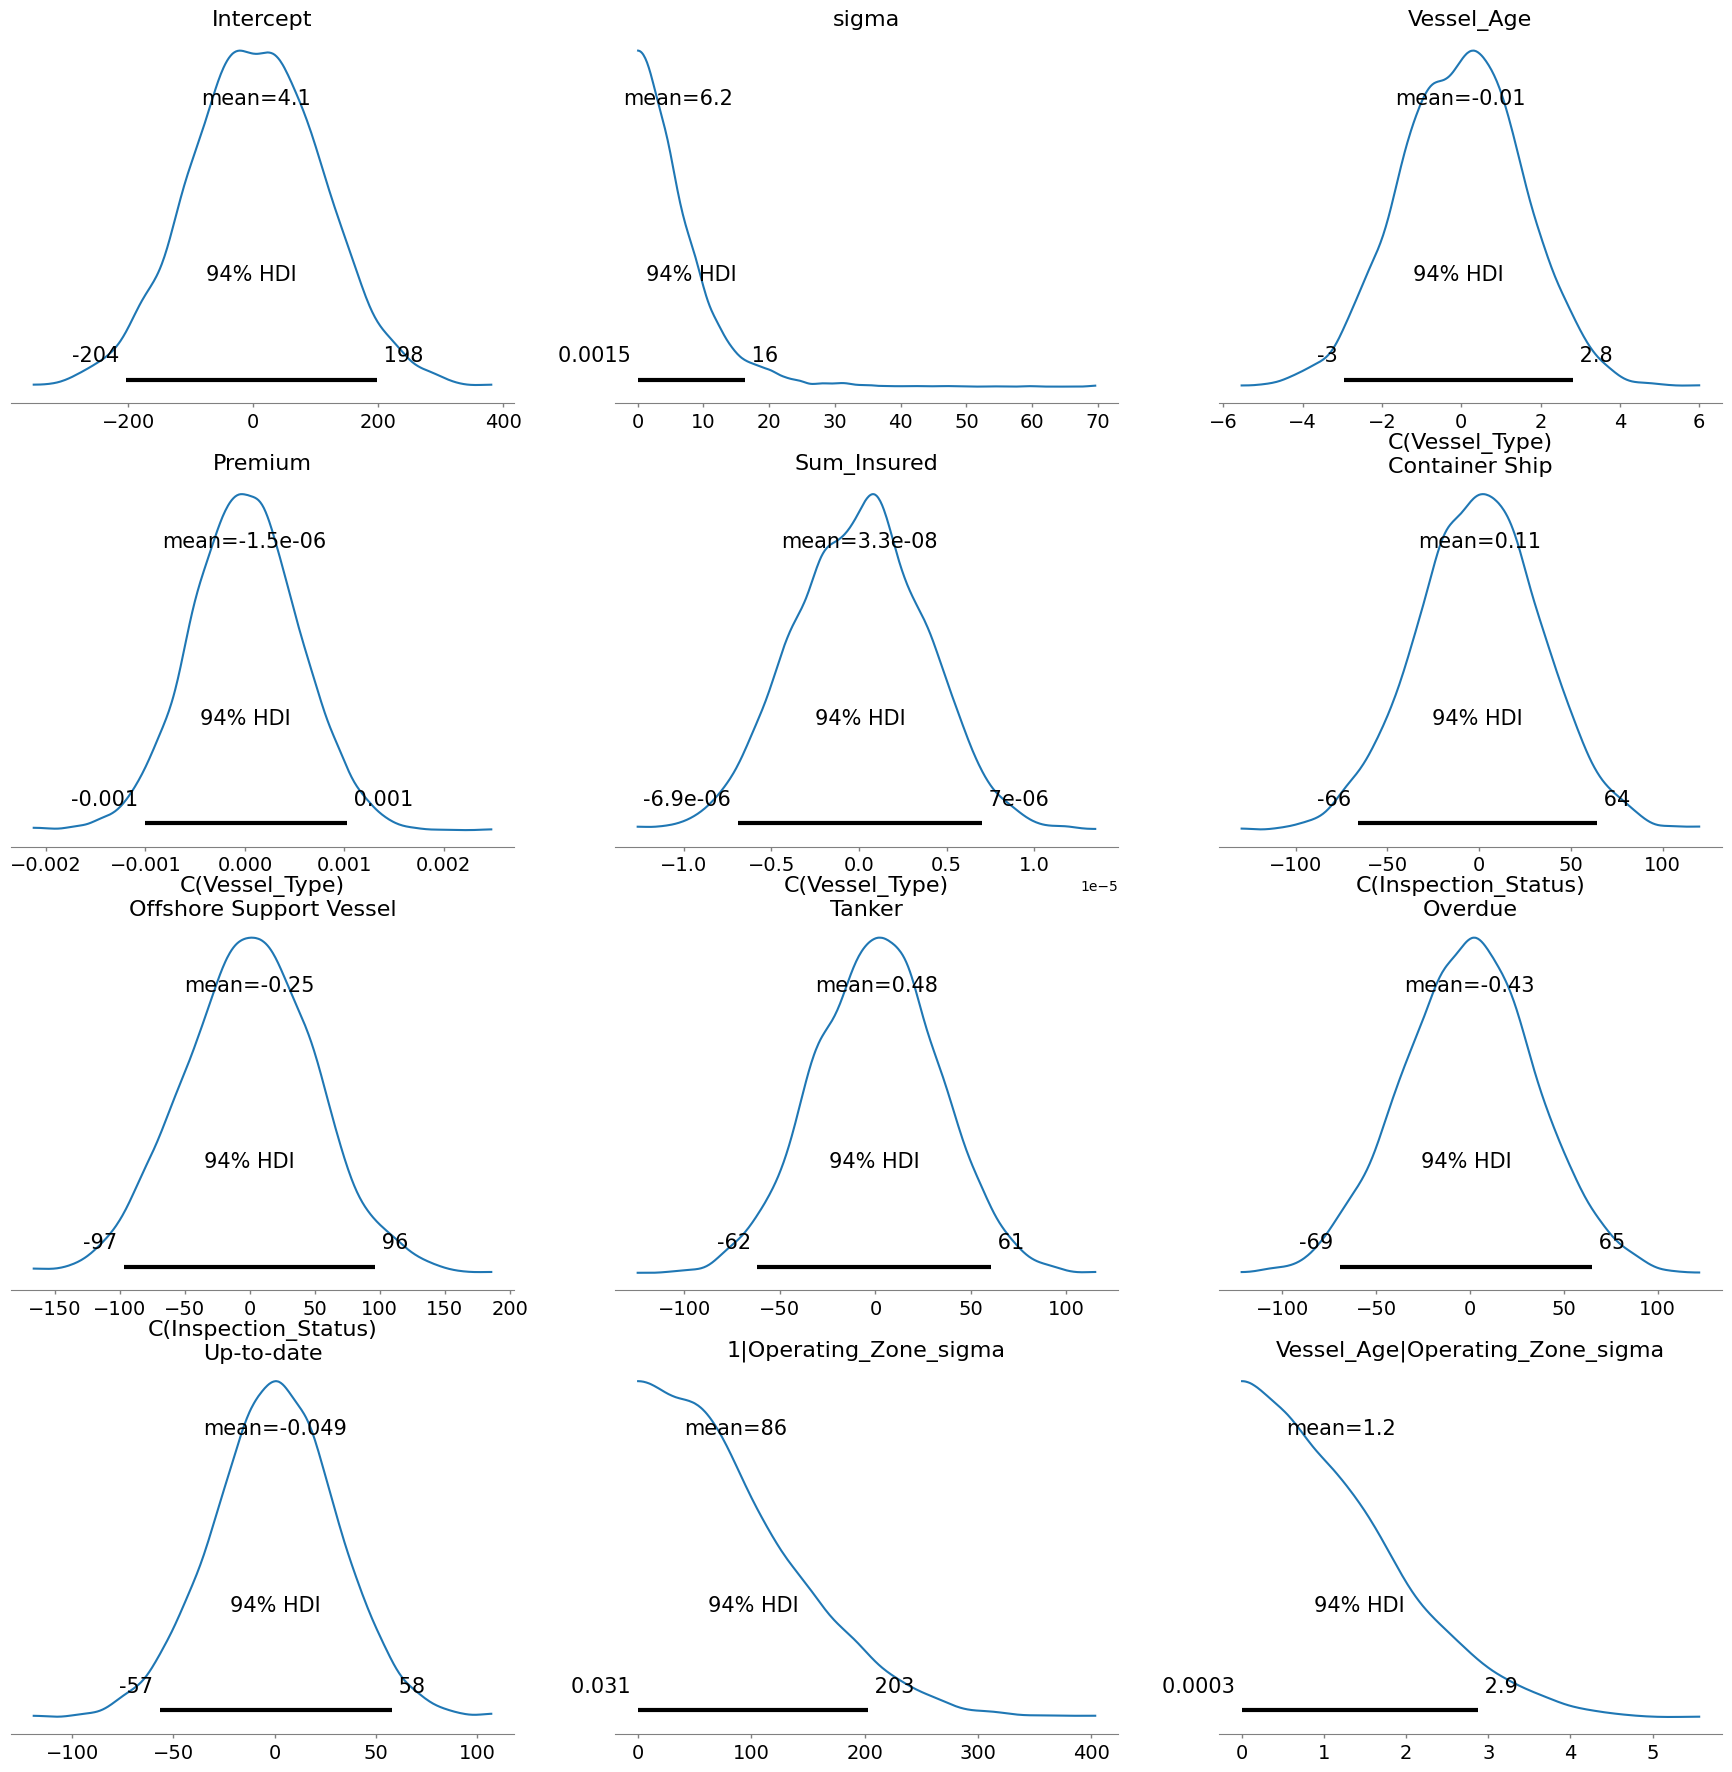

In [44]:
model_bayes.plot_priors()


### Template: Bayesian Mixed Model with PyMC (via Bambi)

```python
import bambi as bmb
model_bayes = bmb.Model(
    'log_claim ~ Vessel_Age + Premium + Sum_Insured + 1 + (1 + Vessel_Age|Operating_Zone) + '
    'C(Vessel_Type) + C(Inspection_Status) + C(Weather_Risk) + C(Piracy_Risk)',
    data=work
)
idata = model_bayes.fit(draws=2000, chains=4, cores=4)
model_bayes.summary()
# Compare: frequentist confidence intervals vs. Bayesian credible intervals.
```
